In [1]:
from numpy import polyfit
from astropy.utils.data import download_file
from astropy.utils.data import Conf 
Conf.remote_timeout = 10
import warnings
warnings.filterwarnings('ignore')
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
class Cepheid(object):
    def __init__(self, **kwargs):
        self.period = kwargs.pop('Period',0)
        self.mag = kwargs.pop('mag',0)
        self.color = kwargs.pop('Color',0)
        self.wmag = self.mag - 0.410 * self.color
        self.Z = kwargs.pop('Z',0)
        self.mag_error = kwargs.pop('e_mag',0)
        self.field = kwargs.pop('Field', '')
        for key, value in kwargs.items():
            setattr(self, key, value)
    def __call__(self, m):
        return 0
    
names = ['Field', 'junk','Sn1a','Filters','mag_av', 'sigma', 'delta_mag','dmag_error','mu_0_Best','mu_best_error']    
class Sne(object):
    def __init__(self, **kwargs):
        self.field = kwargs.pop('Field', '')
        self.name = kwargs.pop('Sn1a', '')
        self.mag_av = kwargs.pop('mag_av',0)
        self.emag_av = kwargs.pop('sigma',0)
        self.delta_mag = kwargs.pop('delta_mag',0)
        self.edelta_mag = kwargs.pop('dmag_error',0)
        self.mu0_best = kwargs.pop('mu_0_Best',0)
        self.emu0_best = kwargs.pop('emu0_Best',0)
        for key, value in kwargs.items():
            setattr(self, key, value)
    def __call__(self, m):
        return 0

In [3]:
class Cepheid_Collection(object):
    def __init__(self, cepheids, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)
        self.cepheids = cepheids
        self.period, self.mag, self.color, self.wmag, self.Z, self.mag_error, self.field = map(array, zip(*[[
                    x.period,
                    x.mag,
                    x.color,
                    x.wmag,
                    x.Z,
                    x.mag_error,
                    x.field
                                                            ] for x in cepheids]))
        self.period
        self.fields = ['n3370', 'n4536', 'n3982', 'n5584', 'n4639', 'n4038', 'n4258', 'n3021', 'n1309']
        self.Z = self.Z

    def plot(self, **kwargs):
        fig = kwargs.pop('fig', figure())
        ax = kwargs.pop('ax', subplot(111))
        field = kwargs.pop('field', self.fields[0])
        error = kwargs.pop('error', False)
        if error == False:
            xvals, yvals = zip(*[(x.period, x.wmag) for x in self.cepheids if x.field == field])
            ax.scatter(xvals, yvals , **kwargs);
            ax.invert_yaxis()
            ax.set_xscale('log')
        if error == True:
            xvals, yvals = zip(*[(x.period, x.wmag) for x in self.cepheids if x.field == field])
            ax.scatter(xvals, yvals , **kwargs);
            ax.invert_yaxis()
            ax.set_xscale('log')
        ax.xaxis.set_major_locator(MaxNLocator(nbins = 4))
        ax.yaxis.set_major_locator(MaxNLocator(nbins = 4))
        plt.close(fig)
        return ax
        
class Sne_Collection(object):
    def __init__(self, Sne, **kwargs):
        for key, value, in kwargs.items():
            setattr(self, key, value)
        self.fields = ['n3370', 'n4536', 'n3982', 'n5584', 'n4639', 'n4038', 'n4258', 'n3021', 'n1309']
        (self.field,self.name,self.mag_av,self.emag_av,
         self.delta_mag,self.edelta_mag,self.mu0_best,self.emu0_best) = map(array, zip(*[[
                    x.field,
                    x.name,
                    x.mag_av,
                    x.emag_av,
                    x.delta_mag,
                    x.edelta_mag,
                    x.mu0_best,
                    x.emu0_best
                                                            ] for x in Sne]))

In [34]:
from scipy.optimize import curve_fit
class PL_Relation():
    def __init__(self, cepheids, **kwargs):
        self.metallicity = kwargs.pop('metallicity', True)
        self.quad = kwargs.pop('quad', False)
        self.cubic = kwargs.pop('cubic', False)
        self.data = cepheids
        self.parnames = [r'%s PL intercept'%field for field in self.data.fields]
        self.parnames.append(r'$b$')
        if self.metallicity: self.parnames.append(r'$Z_p$')
        if self.quad: self.parnames.append(r'$b_2$')
        if self.cubic: self.parnames.append(r'$b_3$')
        
        num_params = len(self.data.fields) + 1 + self.metallicity + self.quad + self.cubic
        for key, value in kwargs.items():
            setattr(self, key, value)

        self.popt, self.pcov = curve_fit(self.fit, 
                                         self.data, 
                                         self.data.wmag,
                                         sigma = self.data.mag_error,
                                         p0 = ones(num_params))

        self.params = dict(zip(self.parnames,self.popt))
    def fit(self, data, *args, **kwargs):
        absolute_mag = kwargs.pop('absolute_mag',False)
        cntr = len(data.fields)
        mag = log10(data.period) * args[cntr]
        cntr += 1
        if self.metallicity:
            mag += (data.Z - 8.9) * args[cntr]
            cntr += 1
        if self.quad:
            mag += log10(data.period)**2 * args[cntr]
            cntr += 1
        if self.cubic:
            mag += log10(data.period)**2 * args[cntr]
            cntr += 1
            
        if not absolute_mag:
            for i, field in enumerate(data.fields):
                mask = array([(el == field) for el in data.field])
                mag += mask * args[i]
        return mag
    
    def __call__(self, val, absolute_mag = False, params = None):
        if params == None: params = self.popt
        return self.fit(val, *params, absolute_mag = absolute_mag)
        

In [35]:
filename = download_file('http://iopscience.iop.org/0004-637X/730/2/119/suppdata/apj383673t2_mrt.txt', cache = True)
data = genfromtxt(filename, 
               skip_header = 39, 
                invalid_raise=False,
                missing_values='',
                usemask=False,
                filling_values=0.0,
                dtype = None);
names = ['Field', 'RAdeg', 'DEdeg', 'ID',  'Period',  'Color',  'mag', 'e_mag', 'Offset', 'Bias', 'IMrms', 'Z']
data = [dict(zip(names, x)) for x in data]
calib_data = Cepheid_Collection([Cepheid(**x) for x in data if x['Field'] == 'n4258'])
data = Cepheid_Collection([Cepheid(**x) for x in data])

In [36]:

filename = download_file('http://iopscience.iop.org/0004-637X/730/2/119/suppdata/apj383673t3_ascii.txt', cache = True)
sne = genfromtxt(filename,
                  skip_header = 4,
                  invalid_raise = False,
                  missing_values = '',
                  usemask=False,
                  filling_values = 0.0,
                  dtype = None
                 );
names = ['Field', 'junk','Sn1a','Filters','mag_av', 'sigma', 'delta_mag','dmag_error','mu_0_Best','mu_best_error']
sne = [dict(zip(names, x)) for x in sne]
sne = Sne_Collection([Sne(**x) for x in sne])

In [37]:
pl_function = PL_Relation(data, metallicity = True)

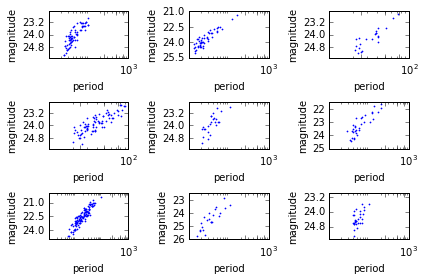

In [38]:
fig = figure();
for i, field in enumerate(data.fields):
    ax = fig.add_subplot(3,3, i+1);
    ax = data.plot(field = field, ax = ax, s= 3, linewidth = 0);
    ax.set_ylabel('magnitude')
    ax.set_xlabel('period')
fig.tight_layout()

param n3370 PL intercept: 28.961
param n4536 PL intercept: 27.809
param n3982 PL intercept: 28.601
param n5584 PL intercept: 28.548
param n4639 PL intercept: 28.517
param n4038 PL intercept: 28.481
param n4258 PL intercept: 26.248
param n3021 PL intercept: 29.076
param n1309 PL intercept: 29.399
param $b$: -2.963
param $Z_p$: -0.224
[ 0.1126125   0.10290143  0.11791244  0.10752411  0.11280634  0.12962228
  0.08961451  0.12769983  0.11716112  0.06041375  0.0963379 ]


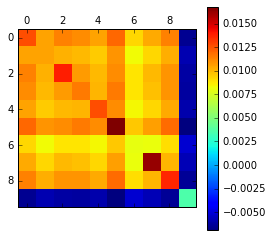

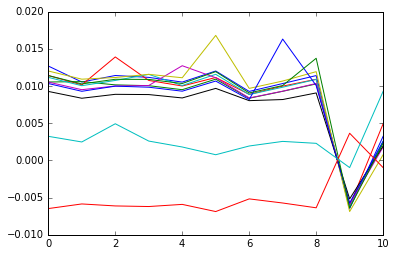

In [39]:
magnitudes = dict(zip(data.fields, pl_function.popt))
delta_magnitudes = dict([(key, val-magnitudes['n4258']) for key, val in magnitudes.iteritems()])
for i, param in enumerate(pl_function.parnames):
    print 'param %s: %1.3f'%(param, pl_function.popt[i])
#for key in delta_magnitudes:
#    print 'Relative intercept for %s is %1.2f'%(key, delta_magnitudes[key])
matshow(pl_function.pcov[:-1,:-1])
colorbar()
figure()
for i in arange(pl_function.pcov.shape[1]):
    plot(pl_function.pcov[:,i])
print sqrt(diag(pl_function.pcov))

blue line: 0.06666547 mag + -1.55
green line: 0.15291189 mag + -3.38


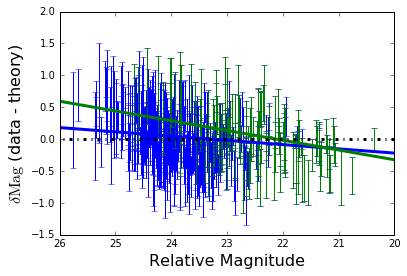

In [40]:

errorbar(data.wmag, data.wmag - pl_function(data), data.mag_error, linestyle='', linewidth = 1, color = 'b')
errorbar(calib_data.wmag, 
         calib_data.wmag - pl_function(calib_data), 
         calib_data.mag_error, 
         linestyle ='', linewidth = 1, color = 'g')
ylabel(r'$\delta {\rm Mag}$ (data - theory)', fontsize = 16)
slope, intercept = polyfit(data.wmag, 
                           array(data.wmag - pl_function(data)), 1, w = 1.0/array(data.mag_error))
print 'blue line: %3.8f mag + %3.2f'%(slope, intercept)
#xvals = linspace(0,250, 1000)
xvals = linspace(20, 26)
plot(xvals, intercept + slope * xvals,color = 'b', linewidth = 3)
slope, intercept = polyfit(calib_data.wmag, 
                           array(calib_data.wmag - pl_function(calib_data)), 1, w = 1.0/array(calib_data.mag_error))
print 'green line: %3.8f mag + %3.2f'%(slope, intercept)
plot(xvals, intercept + slope * xvals,color = 'g', linewidth = 3)
plot(xvals, xvals * 0, linestyle = '-.', linewidth = 3, color = 'k')
gca().invert_xaxis()
xlabel('Relative Magnitude', fontsize = 16)
savefig('/Users/follin/Desktop/resid_plot.png')


blue line: 0.000000 mag + 0.00
green line: 0.035776 mag + 0.15


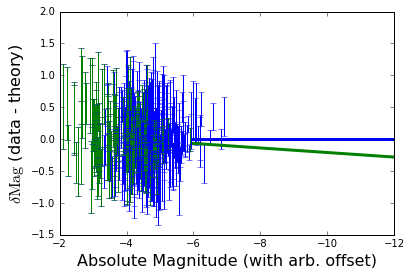

In [41]:

errorbar(pl_function(data, absolute_mag = True), data.wmag - pl_function(data), data.mag_error, linestyle='', linewidth = 1, color = 'b')
errorbar(pl_function(calib_data, absolute_mag = True), 
         calib_data.wmag - pl_function(calib_data), 
         calib_data.mag_error, 
         linestyle ='', linewidth = 1, color = 'g')
ylabel(r'$\delta {\rm Mag}$ (data - theory)', fontsize = 16)
slope, intercept = polyfit(pl_function(data, absolute_mag = True), 
                           array(data.wmag - pl_function(data)), 1, w = 1.0/array(data.mag_error))
print 'blue line: %3.6f mag + %3.2f'%(slope, intercept)
xvals = linspace(-12,-6, 1000)
#xvals = linspace(12,20)
plot(xvals, intercept + slope * xvals,color = 'b', linewidth = 3)
slope, intercept = polyfit(pl_function(calib_data, absolute_mag = True), 
                           array(calib_data.wmag - pl_function(calib_data)), 1, w = 1.0/array(calib_data.mag_error))
print 'green line: %3.6f mag + %3.2f'%(slope, intercept)
plot(xvals, intercept + slope * xvals,color = 'g', linewidth = 3)
xlabel('Absolute Magnitude (with arb. offset)', fontsize = 16)
gca().invert_xaxis()
savefig('/Users/follin/Desktop/resid_plot.png')

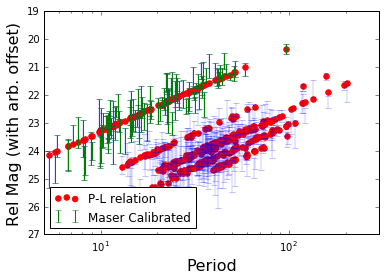

In [42]:

errorbar(data.period, data.wmag, data.mag_error, linestyle='', linewidth = .4, color = 'b', alpha = .5)
errorbar(calib_data.period, 
         calib_data.wmag, 
         calib_data.mag_error, 
         linestyle ='', linewidth = 1, color = 'g', label = 'Maser Calibrated')
xlabel(r'Period', fontsize = 16)
scatter(data.period, pl_function(data),color = 'r', s = 30, label='P-L relation')
ylabel('Rel Mag (with arb. offset)', fontsize = 16)
gca().set_xscale('log')
gca().invert_yaxis()
legend(loc = 3);
xlim(5,300)
savefig('/Users/follin/Desktop/PL_plot.png')
        